<a href="https://colab.research.google.com/github/gsarm78/MetaSegmentation/blob/main/SatelliteImageSegmentation_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/My\ Drive/cs330Data/data2.zip -d /content/data

In [3]:
rm -r /content/data/__MACOSX

In [4]:
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0

     |████████████████████████████████| 378kB 8.2MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 421.8MB 34kB/s 
     |████████████████████████████████| 450kB 47.5MB/s 
     |████████████████████████████████| 3.9MB 50.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=353073f29ad4b4c773708f7e7ff94ffba74d609bf0dc1d7dd07858e5f36de0fb
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    

In [5]:
# Import all the necessary libraries
import os
import datetime
import glob
import random
import sys

import matplotlib.pyplot as plt
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from skimage.morphology import label                  #Used for Run-Length-Encoding RLE to create final submission

import numpy as np
import pandas as pd

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import multi_gpu_model, plot_model
from keras import backend as K
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split


print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)

Using TensorFlow backend.


Python       : 3.6.9 (default, Oct  8 2020, 12:12:24) 
Numpy        : 1.18.5
Skimage      : 0.16.2
Scikit-learn : 0.22.2.post1
Keras        : 2.3.1
Tensorflow   : 2.1.0


In [6]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

In [7]:
# Have a look at our data folder
topDir = '/content' #defaults to '/content' 
os.chdir(topDir)   
print(os.listdir(os.path.join(topDir, 'data'))) 

['labels', 'train']


In [8]:
train_path = os.path.join(topDir, 'data/train')  #path to training data file/folder
label_path = os.path.join(topDir, 'data/labels')
#test_path = os.path.join(topDir, 'data/test')   #path to test data file/folder

In [9]:
%%time
### TAKES MORE THAN 5MINS
import re
img_height, img_width = (256,256)

# Get training data
def get_X_data(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}'.format(path, id) for id in os.listdir(path)]
    img_paths = sorted(img_paths, key=lambda x:float(re.findall("(\d+)",x)[0])) ###FOR SORTING
    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3], output_shape=output_shape, mode='constant', preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    
    return X_data
X_train = get_X_data(train_path, output_shape=(img_height,img_width))
print(X_train.shape, X_train.dtype)

(3903, 256, 256, 3) uint8
CPU times: user 13min 25s, sys: 14min 57s, total: 28min 22s
Wall time: 10min 56s


In [10]:
%%time 
### TAKES MORE THAN 5MINS
# Get training data labels (MASKS)
def get_Y_data(path, output_shape=(None, None)):

    img_paths = ['{0}/{1}'.format(path, id) for id in os.listdir(path)]
    img_paths = sorted(img_paths, key=lambda x:float(re.findall("(\d+)",x)[0])) ###FOR SORTING
    Y_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:1], 
                                                output_shape=output_shape, 
                                                mode='constant', 
                                                preserve_range=True) for path in img_paths], dtype=np.bool)  #take only 1 channels/bands
    return Y_data
Y_train = get_Y_data(label_path, output_shape=(img_height,img_width))
print(Y_train.shape, Y_train.dtype)

(3903, 256, 256, 1) bool
CPU times: user 5min 49s, sys: 8min 14s, total: 14min 3s
Wall time: 4min 43s


(256, 256, 3)


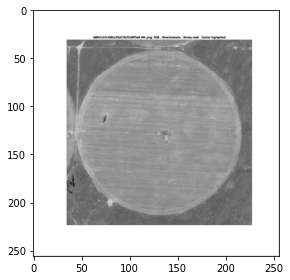

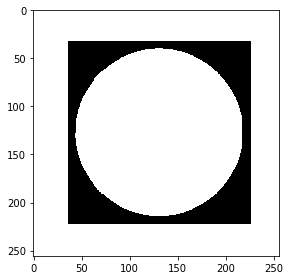

In [60]:
#Visualise masks on the training data
id = 355
print(X_train[id].shape)
skimage.io.imshow(X_train[id])
plt.show()
skimage.io.imshow(Y_train[id][:,:,0])
plt.show()

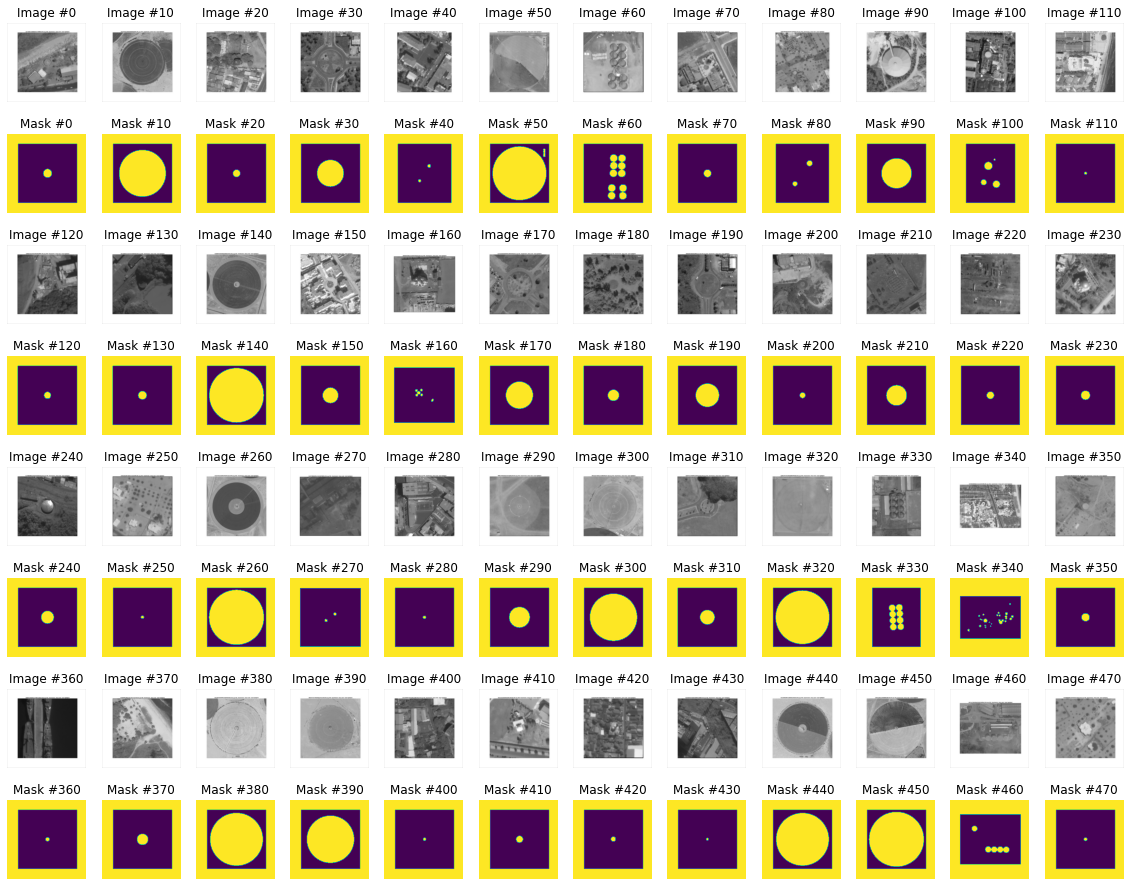

In [12]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
#plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [14]:
pip install segmentation-models

In [61]:
'''
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9) #sigmoid

    model = Model(inputs = inputs, outputs = conv10)

    #model.compile(optimizer = Adam(lr = 1e-4), loss='binary_crossentropy', metrics = ['accuracy']) #binary_crossentropy
    #model.compile(optimizer = Adam(lr = 1e-4), loss=bce_dice_loss, metrics = ['accuracy']) #binary_crossentropy
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model
'''

In [ ]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

BACKBONE = 'inceptionv3'
preprocess_input = get_preprocessing(BACKBONE)

# load your data
#x_train, y_train, x_val, y_val = load_data(...)

# preprocess input
x_train = preprocess_input(X_train)
#x_val = preprocess_input(x_val)

# define model
model = Unet(BACKBONE, classes=1, activation='sigmoid')
#model = unet()
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

# fit model
history=model.fit(
    x=x_train,
    y=Y_train,
    batch_size=16,
    epochs=50, validation_split=0.2)

87916544/87910968 [==============================] - 3s 0us/step
Train on 3122 samples, validate on 781 samples
Epoch 1/50
3122/3122 [==============================] - 75s 24ms/step - loss: 0.1937 - iou_score: 0.9064 - val_loss: 0.4855 - val_iou_score: 0.8669
Epoch 2/50
3122/3122 [==============================] - 47s 15ms/step - loss: 0.0990 - iou_score: 0.9575 - val_loss: 0.2572 - val_iou_score: 0.9359
Epoch 3/50
3122/3122 [==============================] - 47s 15ms/step - loss: 0.0746 - iou_score: 0.9680 - val_loss: 0.0597 - val_iou_score: 0.9740
Epoch 4/50
3122/3122 [==============================] - 47s 15ms/step - loss: 0.0594 - iou_score: 0.9745 - val_loss: 0.1339 - val_iou_score: 0.9419
Epoch 5/50
3122/3122 [==============================] - 47s 15ms/step - loss: 0.0526 - iou_score: 0.9771 - val_loss: 0.0504 - val_iou_score: 0.9798
Epoch 6/50
3122/3122 [==============================] - 46s 15ms/step - loss: 0.0543 - iou_score: 0.9767 - val_loss: 0.1676 - val_iou_score: 0.9458


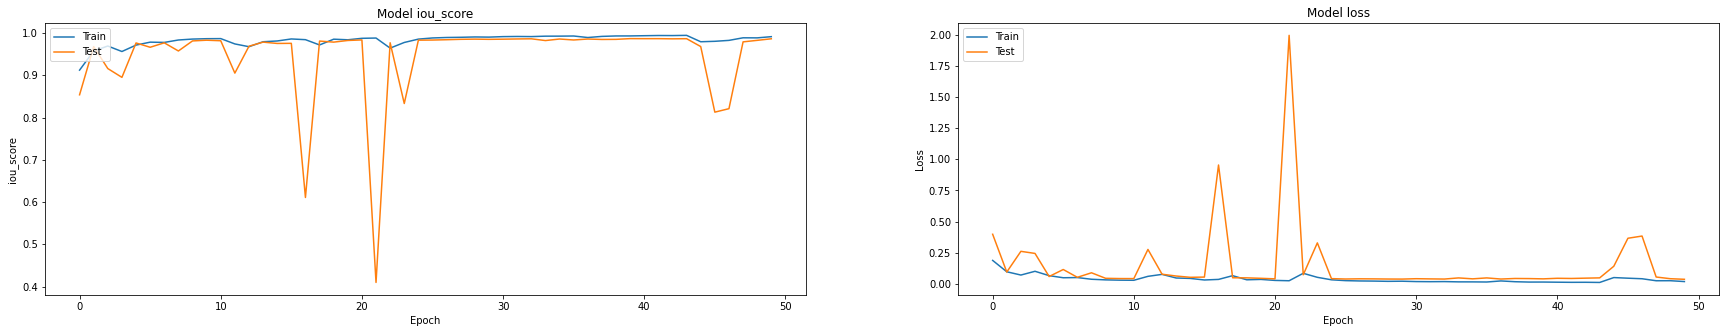

In [66]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [69]:
# Predict on val
preds_val = model.predict(X_train, verbose=1)
preds_val_t = (preds_val > 0.9)

3903/3903 [==============================] - 11s 3ms/step


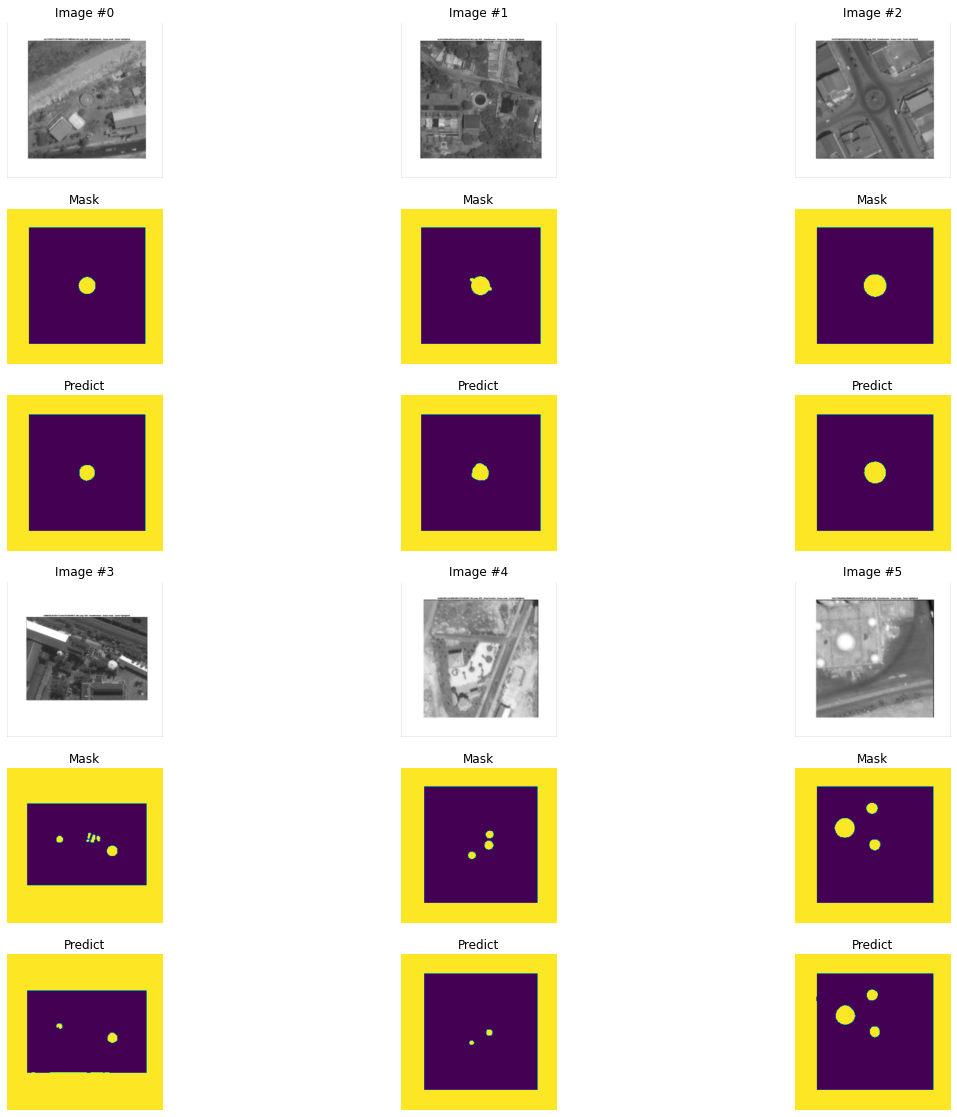

In [70]:
plt.figure(figsize=(20,20))
x, y = 3,2 #cols, rows
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*3, x, i*3*x+j+1)
        pos = i*x+j
        plt.imshow(X_train[pos])
        #plt.title('Image #{}\nIOU {}'.format(pos,round(cal_iou(np.squeeze(Y_val[pos]), np.squeeze(preds_val_t[pos])),2)))
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+1)*x+j+1)
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+2)*x+j+1)
        plt.imshow(np.squeeze(preds_val_t[pos]))
        plt.title('Predict')
        plt.axis('off')
plt.show()

In [41]:
# Save the model weights to a hdf5 file

model.save_weights(filepath=topDir+"/Unet_Satellite-weights.hdf5")
